# Previsão de preços de imóveis em Boston

Esse projeto visa desenvolver um modelo de regressão que seja capaz de prever o valor de imóveis em Boston.

Serão desenvolvidos diferentes modelos de regressão, com diferentes técnicas, visando obter um elevado desemepenho nas predições.

# Importação das bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor

Using TensorFlow backend.
/home/felipe/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/felipe/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/felipe/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/felipe/.local/lib/python3.6/site-packages/tensorflow/python

# Análise inicial dos dados 

Nessa etapa é realizada uma análise preliminar dos dados. É verificado o conjunto de dados e a existência de valores faltantes.

Ambos os conjuntos de dados são importados e um conjunto de dados final é gerado a partir da concatenação de ambos. Isso é útil para algumas análises preliminares dos dados.

In [2]:
DF = pd.read_csv("Data/Train.csv") 
DF_Test = pd.read_csv("Data/Test.csv")

In [3]:
SalePrice = DF["SalePrice"] 
DF.drop(columns = ["SalePrice"], inplace = True) #A coluna "SalePrice" é removida para possibilitar a 
                                                 #concatenação dos dados

In [4]:
Index_DF = DF.shape[0]
Index_DF_Test = DF_Test.shape[0]

In [5]:
DF_Final = pd.concat([DF, DF_Test])

In [6]:
DF.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [7]:
print("The number of NaN values is {}." .format(DF_Final.isna().sum().sum()))

The number of NaN values is 13965.


In [8]:
pd.DataFrame(data = {"NA values": DF.isna().sum(), "Percent": 100*DF.isna().sum()/DF.shape[0]}
                                    ).sort_values(by = "NA values", ascending = False).head()

,NA values,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274


Pode-se verificar que faltam 13965 valores no conjunto de dados. O atributo com mais valores faltantes é o atributos *PoolQC* o qual tem aproximadamente *99.6%* de seus valores faltantes. Isso é devido a maior parte das casas não terem piscina.

# Remocação dos valores faltantes

In [9]:
def remove_nan_data(data):
    """
    Essa função remove os valores faltantes do conjunto de dados, os preenchendo com valores pré-definidos.
    
    Parâmetros
    ----------
    
    data: pd.DataFrame
        conjunto de dados de entrada
        
    Retorno
    -------
    
    data: pd.DataFrame
        conjunto de dados de entrada sem valores faltantes
    
    """
    data = data.copy()
    data["PoolQC"] = data["PoolQC"].fillna("NA")
    data["MiscFeature"] = data["MiscFeature"].fillna("NA")
    data["Alley"] = data["Alley"].fillna("NA")
    data["Fence"] = data["Fence"].fillna("NA")
    data["FireplaceQu"] = data["FireplaceQu"].fillna("NA")
    data["LotFrontage"] = data["LotFrontage"].fillna(-999)
    data["GarageYrBlt"] = data["GarageYrBlt"].fillna(-999)
    data["GarageCond"] = data["GarageCond"].fillna("NA")
    data["GarageType"] = data["GarageType"].fillna("NA")
    data["GarageFinish"] = data["GarageFinish"].fillna("NA")
    data["GarageQual"] = data["GarageQual"].fillna("NA")
    data["BsmtFinType2"] = data["BsmtFinType2"].fillna("NA")
    data["BsmtExposure"] = data["BsmtExposure"].fillna("NA")
    data["BsmtQual"] = data["BsmtQual"].fillna("NA")
    data["BsmtCond"] = data["BsmtCond"].fillna("NA")
    data["BsmtFinType1"] = data["BsmtFinType1"].fillna("NA")
    data["MasVnrArea"] = data["MasVnrArea"].fillna(-999)
    data["MasVnrType"] = data["MasVnrType"].fillna("None")
    data["Electrical"] = data["Electrical"].fillna(DF["Electrical"].mode()[0])
    data["MSZoning"] = data["MSZoning"].fillna(data["MSZoning"].mode()[0])
    data["BsmtFullBath"] = data["BsmtFullBath"].fillna(-999)
    data["BsmtHalfBath"] = data["BsmtHalfBath"].fillna(-999)
    data["Functional"] = data["Functional"].fillna(data["Functional"].mode()[0])
    data["Utilities"] = data["Utilities"].fillna(data["Utilities"].mode()[0])
    data["Exterior2nd"] = data["Exterior2nd"].fillna(data["Exterior2nd"].mode()[0])
    data["BsmtFinSF2"] = data["BsmtFinSF2"].fillna(-999)
    data["GarageArea"] = data["GarageArea"].fillna(-999)
    data["BsmtFinSF1"] = data["BsmtFinSF1"].fillna(-999)
    data["GarageCars"] = data["GarageCars"].fillna(-999)
    data["TotalBsmtSF"] = data["TotalBsmtSF"].fillna(-999)
    data["BsmtUnfSF"] = data["BsmtUnfSF"].fillna(-999)
    data["Exterior1st"] = data["Exterior1st"].fillna(data["Exterior1st"].mode()[0])
    data["SaleType"] = data["SaleType"].fillna(data["SaleType"].mode()[0])
    data["Exterior1st"] = data["Exterior1st"].fillna(data["Exterior1st"].mode()[0])
    data["KitchenQual"] = data["KitchenQual"].fillna(data["KitchenQual"].mode()[0])
    return data

In [10]:
DF_Final = remove_nan_data(DF_Final)

In [11]:
pd.DataFrame(data = {"NA values": DF_Final.isna().sum(), "Percent": 100*DF_Final.isna().sum()/DF_Final.shape[0]}
                                    ).sort_values(by = "NA values", ascending = False).head()

,NA values,Percent
Id,0,0.0
MSSubClass,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0
Fireplaces,0,0.0


Pode-se verificar que após a função **remove_nan_data** ser aplicada ao conjunto de dados, os dados faltantes foram completamente eliminados.

# Exploração inicial dos dados

Nesse momento uma análise dos dados será realizada. Serão definidas formas de se tratar os dados categóricos bem como possíveis transformações nos dados numéricos. Essa etapa é de vital importância para um bom desempenho do algoritmo de aprendizado de máquina.

In [12]:
def get_numerical_categorical_number(data):
    """
    Essa função recebe um conjunto de dados e verifica quais de seus atributos são numéricos e quais não são.
    
    Parâmetros
    ---------
    
    data: pd.DataFrame
        conjunto de dados a ser analisado
    
    """
    numerical = []
    categorical = []
    for col in data.columns:
        if data[col].dtype != "O":
            numerical.append(col)
        else:
            categorical.append(col)
    return numerical, categorical

In [13]:
n_data, c_data = get_numerical_categorical_number(DF_Final)

In [14]:
DF_Final.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,0,0,NA,NA,NA,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,0,0,NA,NA,NA,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,0,0,NA,NA,NA,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,0,0,NA,NA,NA,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,0,0,NA,NA,NA,0,12,2008,WD,Normal


Pode-se verifica que existem muitos atributos categóricos no conjunto de dados. Como os modelos de predição somente lidam com dados numéricos todos os atributos categóricos precisam ser transformados em atributos numéricos.

In [15]:
def replace_qlt_features(data):
    """
    Essa função substitui os atributos envolvendo qualidade por uma escala numérica de 0 a 5.
    
    Parâmetros
    ----------
    
    data: pd.DataFrame
        conjunto de dados a ser analisado
    
    """
    data = data.copy()
    replace_data = {
        "Ex": 5,
        "Gd": 4,
        "TA": 3,
        "Fa": 2,
        "Po": 1,
        "NA": 0,
    }
    qlt_features = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", 
                   "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"]
    for qlt in qlt_features:
        data[qlt] = data[qlt].replace(replace_data)
    return data

In [16]:
DF_Final = replace_qlt_features(DF_Final)

In [17]:
_, c_data = get_numerical_categorical_number(DF_Final)

In [18]:
class MultiColumnLabelEncoder():
    def __init__(self, columns_list):
        self.columns_list = columns_list
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        x = x.copy()
        for col in self.columns_list:
            x[col] = LabelEncoder().fit_transform(x[col])
        return x
    
    def fit_transform(self, x, y=None):
        return self.fit(x).transform(x)

In [19]:
def transform_categorical_data(data, categorical_data):
    data = data.copy()
    MCLE = MultiColumnLabelEncoder(categorical_data)
    data = MCLE.fit_transform(data)
    return data

In [20]:
DF_Final = transform_categorical_data(DF_Final, c_data)

In [21]:
DF = DF_Final.iloc[0:Index_DF].copy()
DF["SalePrice"] = SalePrice
DF_Test = DF_Final.iloc[Index_DF:(Index_DF + Index_DF_Test)].copy()

# Visualização dos atributos

Agora serão verificadas possíveis relações entre os atributos do conjunto de dados é o preço dos imóveis.

In [22]:
def plot_numerical_data(data):
    n_rows = int(data.shape[1]/2) + 1
    y = data["SalePrice"]
    plt.figure(figsize = (20, 160))
    for i, col in enumerate(data.columns):
        plt.subplot(n_rows, 2, (i + 1))
        plt.scatter(data[col], y)
        plt.xlabel(col)
        plt.ylabel("SalePrice")
        plt.grid()

In [23]:
DF.drop(columns = ["Id"], inplace = True) #Eliminação da coluna Id, a qual é irrelevante para a predição
DF_Test.drop(columns = ["Id"], inplace = True) #Eliminação da coluna Id, a qual é irrelevante para a predição

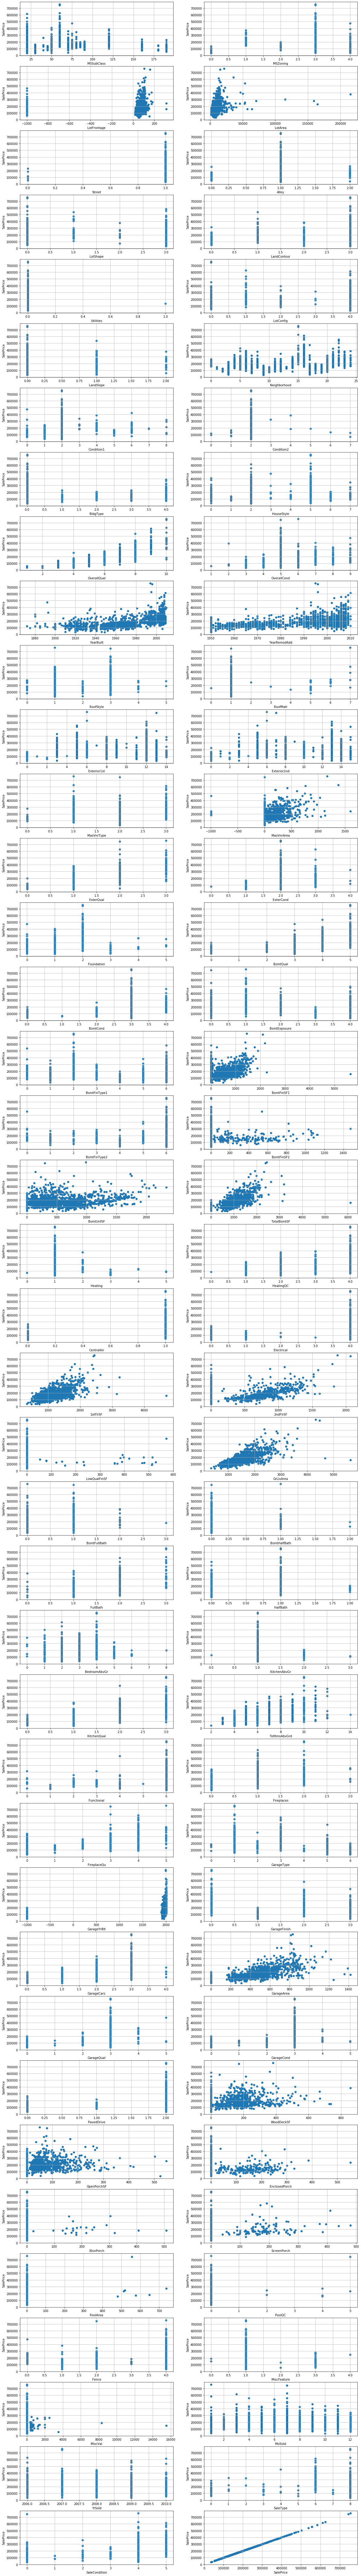

In [24]:
plot_numerical_data(DF)

In [25]:
DF.drop(columns = ["Utilities"], inplace = True)      #Remoção da coluna Utilities, a qual contem basicamente o
DF_Test.drop(columns = ["Utilities"], inplace = True) #mesmo dado

As variáveis referentes a anos ou meses não serão tratadas como numéricas, visto que seu significado é um pouco diferente de um número qualquer. Devido a isso todas as entradas dessas colunas serão transformadas em atributos categóricos.

In [26]:
# DF["YrSold"] = DF["YrSold"].apply(lambda x: str(x))
# DF["GarageYrBlt"] = DF["GarageYrBlt"].apply(lambda x: str(x))
# DF["YearRemodAdd"] = DF["YearRemodAdd"].apply(lambda x: str(x))
# DF["YearBuilt"] = DF["YearBuilt"].apply(lambda x: str(x))
# DF_Test["YrSold"] = DF_Test["YrSold"].apply(lambda x: str(x))
# DF_Test["GarageYrBlt"] = DF_Test["GarageYrBlt"].apply(lambda x: str(x))
# DF_Test["YearRemodAdd"] = DF_Test["YearRemodAdd"].apply(lambda x: str(x))
# DF_Test["YearBuilt"] = DF_Test["YearBuilt"].apply(lambda x: str(x))

Alguns atributos são removidos da lista de atributos iniciais

In [27]:
n_data.remove("Id")
# n_data.remove("YrSold")
# n_data.remove("GarageYrBlt")
# n_data.remove("YearRemodAdd")
# n_data.remove("YearBuilt")
# n_data.remove("MoSold")

In [28]:
class StandardScalerModified():
    def __init__(self):
        self.numerical_features = n_data
    
    def fit(self, x, y=None):
        x = x.copy()
        self.SC = StandardScaler()
        self.SC.fit(x[self.numerical_features])
        return self
    
    def transform(self, x, y=None):
        x = x.copy()
        x_t = self.SC.transform(x[self.numerical_features])
        x[self.numerical_features] = x_t
        return x
    
    def fit_transform(self, x, y=None):
        return self.fit(x).transform(x)

In [29]:
DF_dummies = pd.get_dummies(DF, drop_first = True)           #Criação do conjunto de dados final
DF_Test_dummies = pd.get_dummies(DF_Test, drop_first = True) #Criação do conjunto de dados final

# Criação do conjunto de treinamento e  teste

In [30]:
x = DF_dummies.drop(columns = ["SalePrice"])
y = np.log1p(DF_dummies["SalePrice"])

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

# Remoção de outliers 

Agora os *outliers* presentes no conjunto de dados serão removidos. Devido ao pequeno tamanho do conjunto de dados isso será realizado de forma manual, por meio dos gráficos de cada atributo. Em conjuntos de dados maiores algumas técnicas estatísticas podem ser utilizadas para acelerar o processo.

In [32]:
def verify_data(x_train, y_train):
    row = int(len(n_data)/2) + 1
    plt.figure(figsize = (20, 80))
    for i, label in enumerate(n_data):
        plt.subplot(row, 2, (i + 1))
        plt.scatter(x_train[label], y_train)
        plt.xlabel(label)
        plt.ylabel("SalePrice")
        plt.grid()

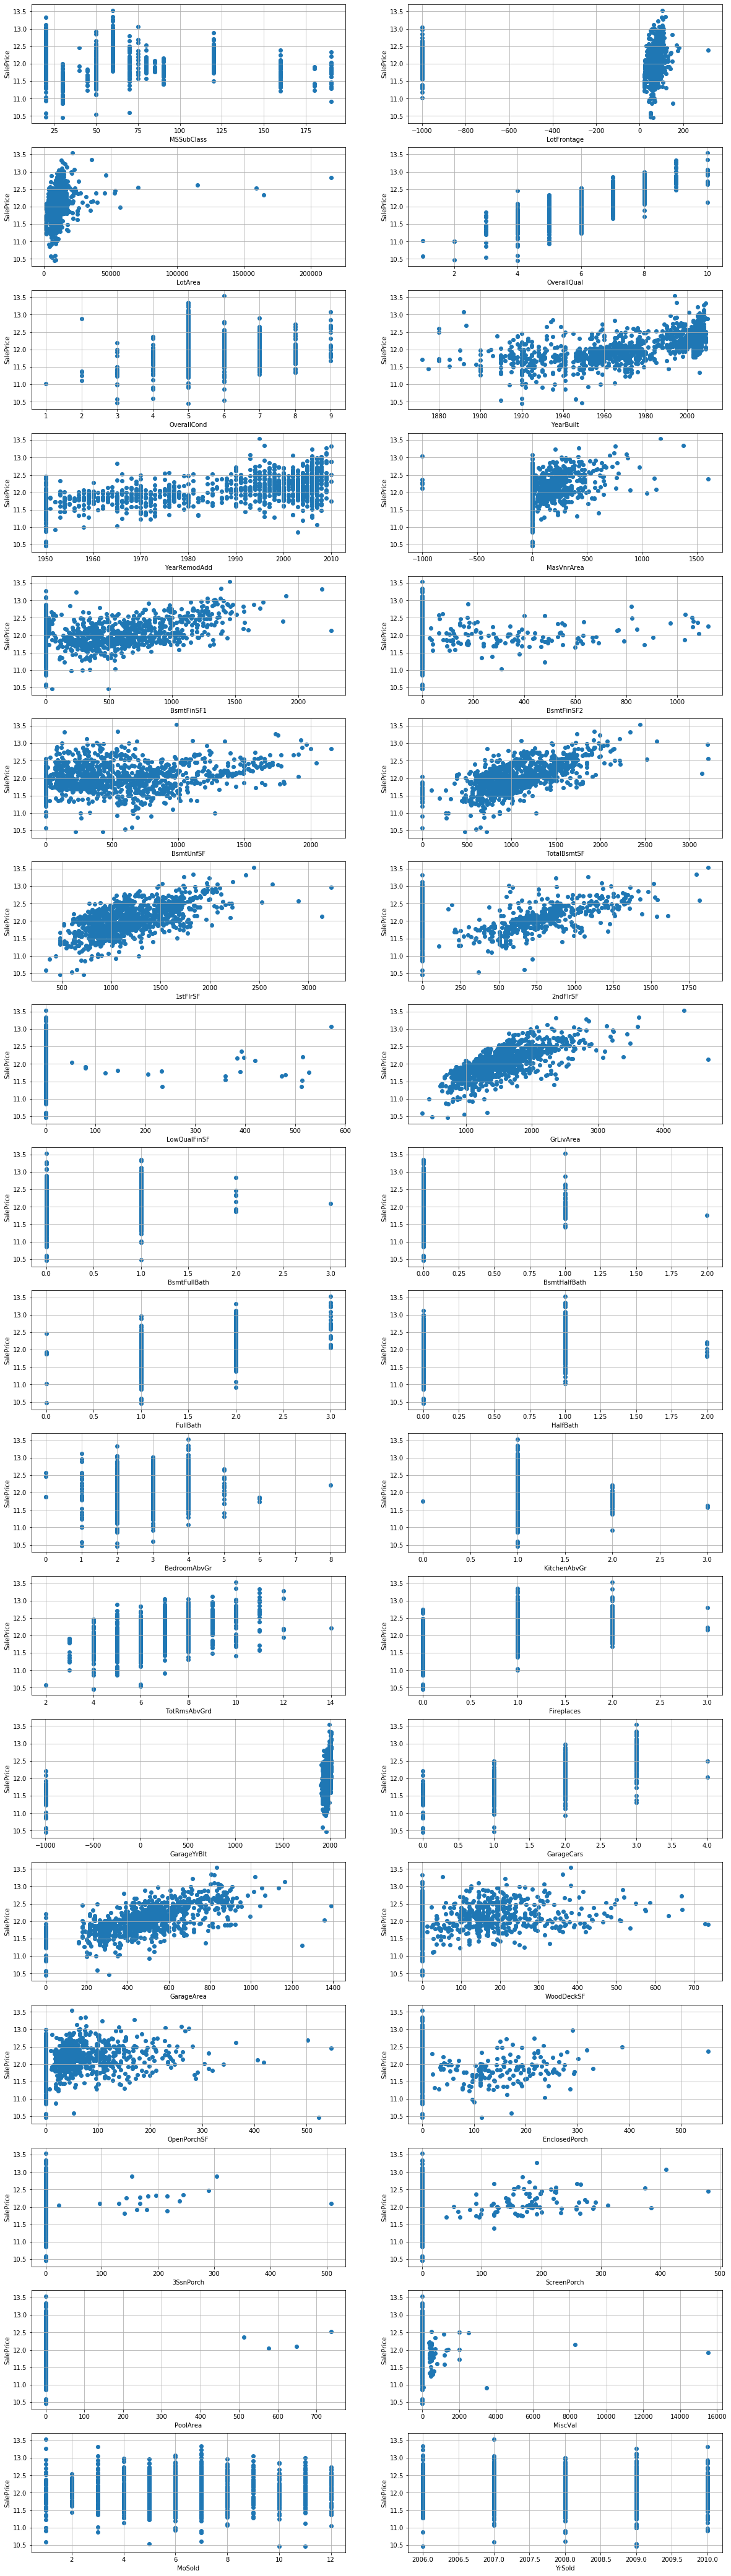

In [33]:
verify_data(x_train, y_train)

Aqui os *outliers* são removidos.

In [34]:
print("Original shape {}" .format(x_train.shape[0]))

x_train["SalePrice"] = y_train
x_train = x_train[x_train["LotFrontage"] < 200]
x_train = x_train[x_train["LotArea"] < 100000]
x_train = x_train[x_train["BsmtFinSF1"] < 2000]
x_train = x_train[x_train["GrLivArea"] < 4000]
x_train = x_train[x_train["GarageArea"] < 1200]
x_train = x_train[x_train["3SsnPorch"] < 500]
x_train = x_train[x_train["EnclosedPorch"] < 500]
x_train = x_train[x_train["MiscVal"] < 8000]
y_train = x_train["SalePrice"]
x_train.drop(columns = ["SalePrice"], inplace = True)

print("Final shape {}" .format(x_train.shape[0]))

Original shape 1168
Final shape 1153


/home/felipe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Desenvolvimento do modelo 

A última parte do projeto envolve o desenvolvimento do modelo para predição dos preços. Nessa etapa os modelos serão desenvolvidos visando a maximização da sua performance. Os modelos desenvolvidos serão os seguintes:

- Regressão linear;
- Regressão Ridge;
- Regressão Lasso;
- Gradient Boosting Regressor;
- Modelo de regressão neural.

O primeiro modelo desenvolvido é um modelo de **regressão linear**, o mais simples dentre os modelos desenvolvidos.

In [35]:
def train_test_linear_model(x_train, y_train):
    """
    Essa função cria um modelo de regressão linear e faz uma validação cruzada para verificar sua performance.
    
    Parâmetros
    ----------
    
    x_train: pd.DataFrame
        conjunto de atributos do modelo
    y_train: np.ndarray
        variável a ser predita
    
    Retorno
    -------
    
    LR: 
        modelo de regressão linear
        
    """
    MP = make_pipeline(StandardScalerModified(), LinearRegression())
    score = cross_val_score(MP, x_train, y_train, cv = 5, scoring = "neg_mean_squared_error")
    score = -1*score
    score = np.sqrt(score)
    for i, sc in enumerate(score):
        print("Iteração {}, score {:.4f}." .format(i, sc))
    print("O valor de score médio for {:.4f}" .format(np.mean(score)))
    plt.figure(figsize = (20, 10))
    sns.barplot(np.arange(1, 6, 1), score)
    plt.grid()
    plt.title("Scores of cross-validation")
    plt.xlabel("CV")
    plt.ylabel("RMSE")
    MP.fit(x_train, y_train)
    return MP

Iteração 0, score 0.1063.
Iteração 1, score 0.1434.
Iteração 2, score 0.1461.
Iteração 3, score 0.1056.
Iteração 4, score 0.1097.
O valor de score médio for 0.1222


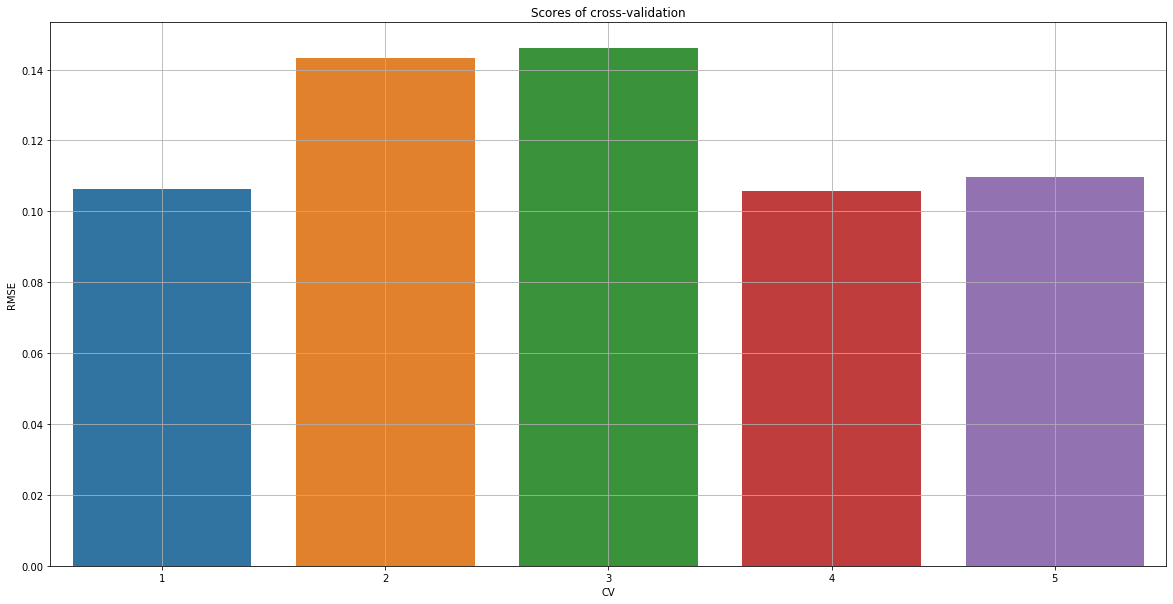

In [36]:
LR = train_test_linear_model(x_train, y_train)

Pode-se verificar que o desempenho desse modelo foi ruim, evidenciando sua simplicidade.

O segundo modelo desenvolvido é a **regressão Ridge**. Esse modelo é uma regressão linear com regularização em seus parâmetros, o que melhora a capacidade preditora do modelo bem como diminui as interferencias oriundas da multicolinearidade dos atributos.

In [37]:
def train_test_ridge_regression(x_train, y_train):
    """
    Essa função procura o melhor valor do parâmetros de regularização para um modelo de Ridge de regressão.
    
    Parâmetros
    ----------
    
    x_train: pd.DataFrame
        conjunto de atributos do modelo
    y_train: np.ndarray
        variável a ser predita
    
    Retorno
    -------
    
    RI: 
        modelo de regressão Ridge (pipeline envolvendo o padronizador dos dados)
        
    """
    lambda_values = np.logspace(-2, 2, 100)
    parameter_grid = {
        "ridge__alpha": lambda_values
    }
    MP = make_pipeline(StandardScalerModified(), Ridge())
    Grid = GridSearchCV(MP, parameter_grid, cv = 5, scoring = "neg_mean_squared_error")
    Grid.fit(x_train, y_train)
    RI = Grid.best_estimator_
    print("Best parameter {}" .format(Grid.best_params_["ridge__alpha"]))
    print("The best score is {}" .format(np.sqrt(-1*Grid.best_score_)))
    score = cross_val_score(RI, x_train, y_train, cv = 5, scoring = "neg_mean_squared_error")
    score = np.sqrt(-1*score)
    score_list = score
    best_mean_score = np.mean(score)
    for i, score in enumerate(score_list):
        print("Iteração {}, score {:.4f}." .format(i, score))
    print("O melhor valor de score médio for {:.4f}" .format(best_mean_score))
    plt.figure(figsize = (20, 10))
    sns.barplot(np.arange(1, 6, 1), score_list)
    plt.grid()
    plt.title("Scores of cross-validation")
    plt.xlabel("CV")
    plt.ylabel("RMSE")
    return RI

Best parameter 39.4420605943766
The best score is 0.12138615253539463
Iteração 0, score 0.1009.
Iteração 1, score 0.1405.
Iteração 2, score 0.1433.
Iteração 3, score 0.1068.
Iteração 4, score 0.1085.
O melhor valor de score médio for 0.1200


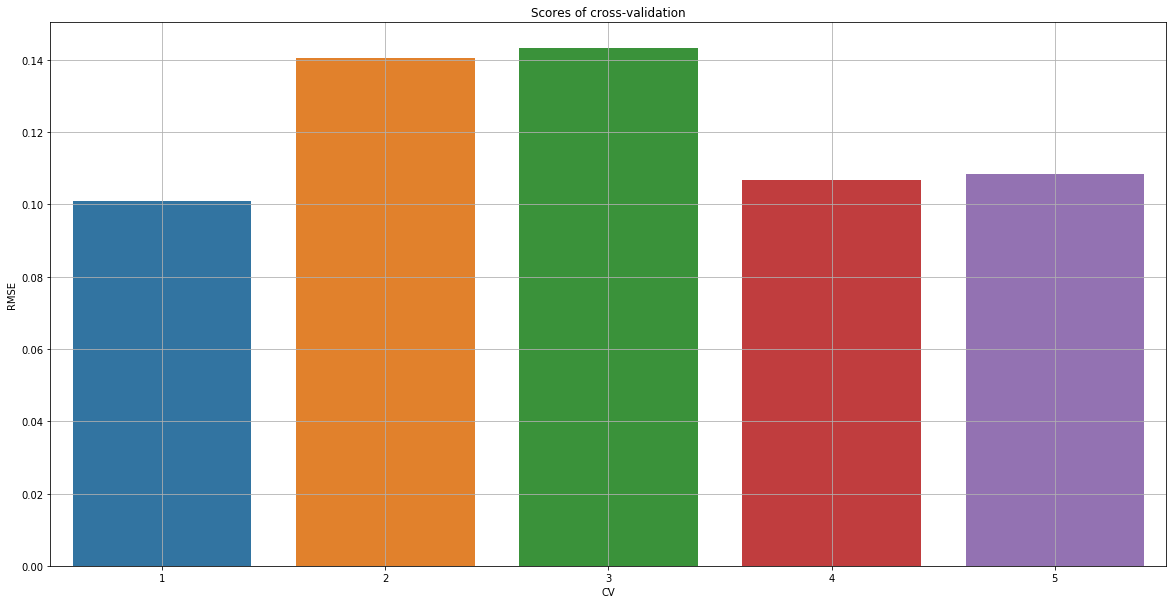

In [38]:
RI = train_test_ridge_regression(x_train, y_train)

Pode-se verificar que esse modelo teve uma boa performance, mostrando RMSE relativamente baixo.

O segundo modelo desenvolvido é a **regressão Lasso**. Esse modelo é análogo ao anterior, suas únicas diferenças são na técnica de regularização aplicada.

In [39]:
def train_test_lasso_regression(x_train, y_train):
    """
    Essa função procura o melhor valor do parâmetros de regularização para um modelo de Ridge de regressão.
    
    Parâmetros
    ----------
    
    x_train: pd.DataFrame
        conjunto de atributos do modelo
    y_train: np.ndarray
        variável a ser predita
    
    Retorno
    -------
    
    LA: 
        modelo de regressão Lasso (pipeline envolvendo o padronizador dos dados)
        
    """
    lambda_values = np.logspace(-3, 3, 500)
    parameter_grid = {
        "alpha": lambda_values
    }
    LA = Lasso()
    Grid = GridSearchCV(LA, parameter_grid, cv = 5, scoring = "neg_mean_squared_error")
    Grid.fit(x_train, y_train)
    LA = Grid.best_estimator_
    print("Best parameter {}" .format(Grid.best_params_["alpha"]))
    print("The best score is {}" .format(np.sqrt(-1*Grid.best_score_)))
    score = cross_val_score(LA, x_train, y_train, cv = 5, scoring = "neg_mean_squared_error")
    score = np.sqrt(-1*score)
    score_list = score
    best_mean_score = np.mean(score)
    for i, score in enumerate(score_list):
        print("Iteração {}, score {:.4f}." .format(i, score))
    print("O melhor valor de score médio for {:.4f}" .format(best_mean_score))
    plt.figure(figsize = (20, 10))
    sns.barplot(np.arange(1, 6, 1), score_list)
    plt.grid()
    plt.title("Scores of cross-validation")
    plt.xlabel("CV")
    plt.ylabel("RMSE")
    return LA

Best parameter 0.001
The best score is 0.12153939881083432
Iteração 0, score 0.1012.
Iteração 1, score 0.1420.
Iteração 2, score 0.1419.
Iteração 3, score 0.1049.
Iteração 4, score 0.1108.
O melhor valor de score médio for 0.1202


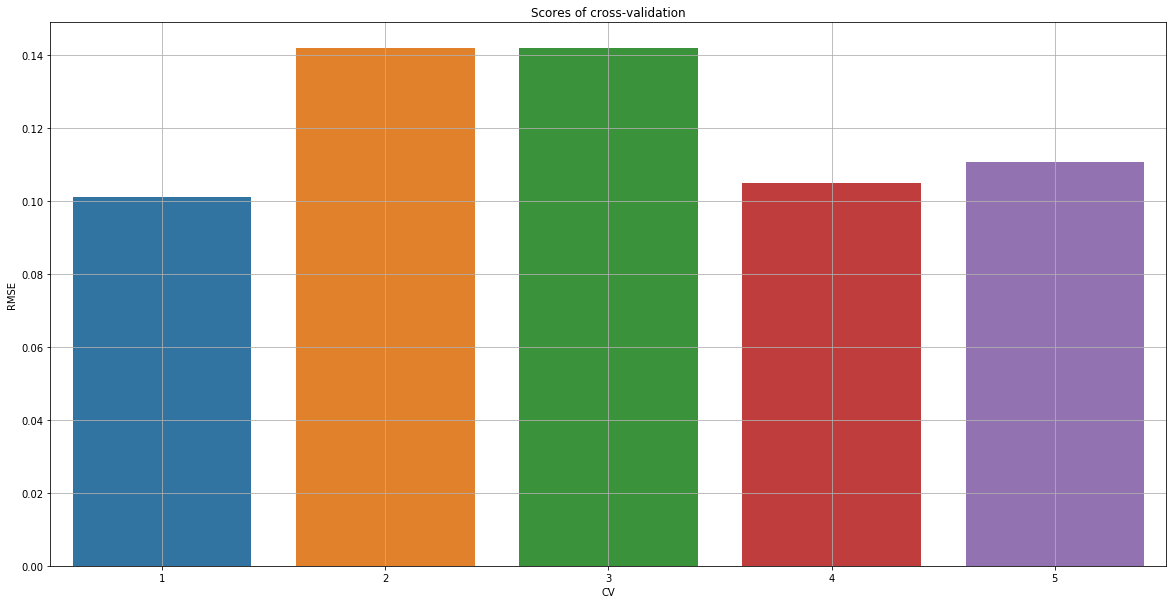

In [40]:
LA = train_test_lasso_regression(x_train, y_train)

Pode-se verificar que esse modelo também teve uma boa performance.

In [41]:
def train_test_gbr(x_train, y_train):
    """
    Essa função treina um modelo de Gradient Boosting Regressor.
    
    Parâmetros
    ----------
    
    x_train: pd.DataFrame
        conjunto de atributos do modelo
    y_train: np.ndarray
        variável a ser predita
    
    Retorno
    -------
    
    GBR: 
        modelo de Gradient Boosting Regressor (pipeline envolvendo o padronizador dos dados)
        
    """
    GBR = GradientBoostingRegressor(
                                    loss = "huber",
                                    n_estimators = 250,
                                    alpha = 0.905,
                                    min_samples_split = 5,
                                    min_samples_leaf = 2,
                                    max_features = "sqrt",
                                    subsample = 1,
                                   )
    
    MP = make_pipeline(StandardScalerModified(), GBR)
    score = cross_val_score(MP, x_train, y_train, cv = 5, scoring = "neg_mean_squared_error")
    score = np.sqrt(-1*score)
    score_list = score
    best_mean_score = np.mean(score)
    for i, score in enumerate(score_list):
        print("Iteração {}, score {:.4f}." .format(i, score))
    print("O melhor valor de score médio for {:.4f}" .format(best_mean_score))
    plt.figure(figsize = (20, 10))
    sns.barplot(np.arange(1, 6, 1), score_list)
    plt.grid()
    plt.title("Scores of cross-validation")
    plt.xlabel("CV")
    plt.ylabel("RMSE")
    MP.fit(x_train, y_train)
    return MP

Iteração 0, score 0.0861.
Iteração 1, score 0.1377.
Iteração 2, score 0.1374.
Iteração 3, score 0.1086.
Iteração 4, score 0.1057.
O melhor valor de score médio for 0.1151


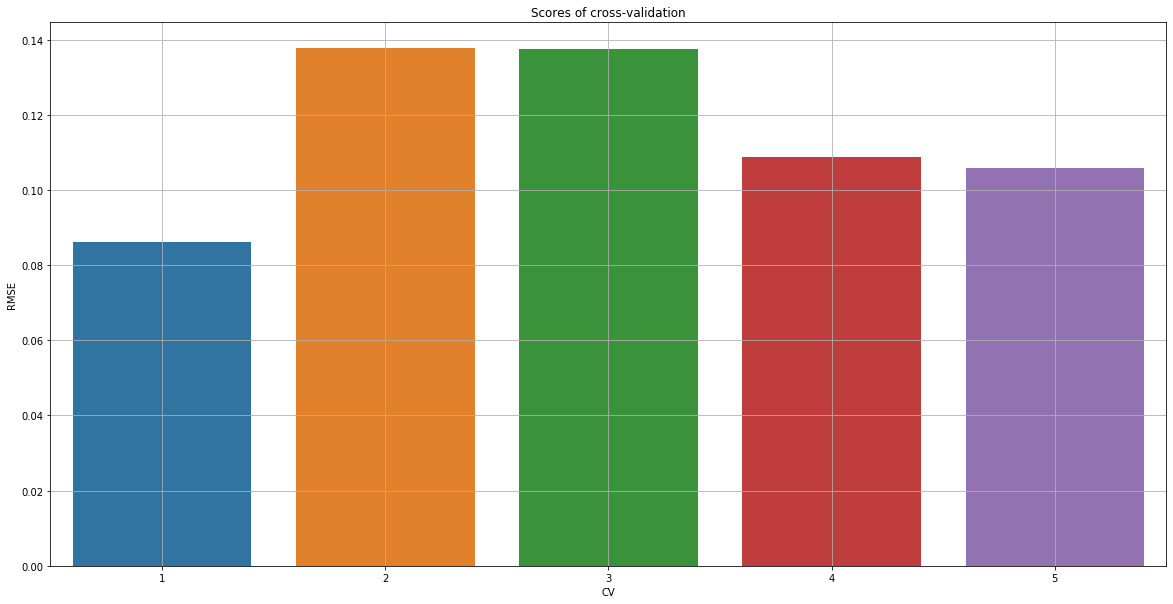

In [42]:
GBR = train_test_gbr(x_train, y_train)

Pode-se verificar que esse modelo tem um elevado desempenho em comparação aos outros. Isso ocorre devido a esse modelo ser um modelo *ensemble* o que significa que ele é uma composição de outros modelos.

In [43]:
def train_test_keras_regressor(x_train, y_train):
    """
    Essa função treina um modelo neural de regressão.
    
    Parâmetros
    ----------
    
    x_train: pd.DataFrame
        conjunto de atributos do modelo
    y_train: np.ndarray
        variável a ser predita
    
    Retorno
    -------
    
    MD: 
        modelo de regressão neural (pipeline envolvendo o padronizador dos dados)
        
    """
    x_train_keras = StandardScalerModified().fit_transform(x_train)
    x_train, x_val, y_train, y_val = train_test_split(x_train_keras, y_train, test_size = 0.2, random_state = 0)
    MC = ModelCheckpoint("Best_Model.hdf5", monitor = "val_mse")
    MD = Sequential()
    MD.add(Dense(100, input_dim = 78, activation = "sigmoid"))
    MD.add(Dropout(0.3))
    MD.add(Dense(100, activation = "sigmoid"))
    MD.add(Dropout(0.3))
    MD.add(Dense(100, activation = "sigmoid"))
    MD.add(Dropout(0.3))
    MD.add(Dense(100, activation = "sigmoid"))
    MD.add(Dropout(0.3))
    MD.add(Dense(1, activation = "linear"))
    MD.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ["mse"])
    data = MD.fit(x_train, y_train, epochs = 500, validation_data = (x_train, y_train), batch_size = 30, callbacks = [MC], verbose = 0)
    MD.load_weights("Best_Model.hdf5")
    MD.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ["mse"])
    print("Validation RMSE: {:.4f}" .format(np.sqrt(MD.evaluate(x_val, y_val, verbose = 0)[1])))
    plt.figure(figsize = (20, 10))
    plt.subplot(2, 2, 1)
    plt.title("Model Loss")
    plt.plot(data.history["loss"])
    plt.grid()
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.subplot(2, 2, 2)
    plt.title("Validation Loss")
    plt.plot(data.history["val_loss"])
    plt.grid()
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.subplot(2, 2, 3)
    plt.title("Model MSE")
    plt.plot(data.history["mse"])
    plt.grid()
    plt.xlabel("Iteration")
    plt.ylabel("MSE")
    plt.subplot(2, 2, 4)
    plt.title("Validation MSE")
    plt.plot(data.history["val_mse"])
    plt.grid()
    plt.xlabel("Iteration")
    plt.ylabel("MSE")
    plt.show()
    return MD

W1006 18:49:16.489653 139858713446208 deprecation_wrapper.py:119] From /home/felipe/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Validation RMSE: 0.2061


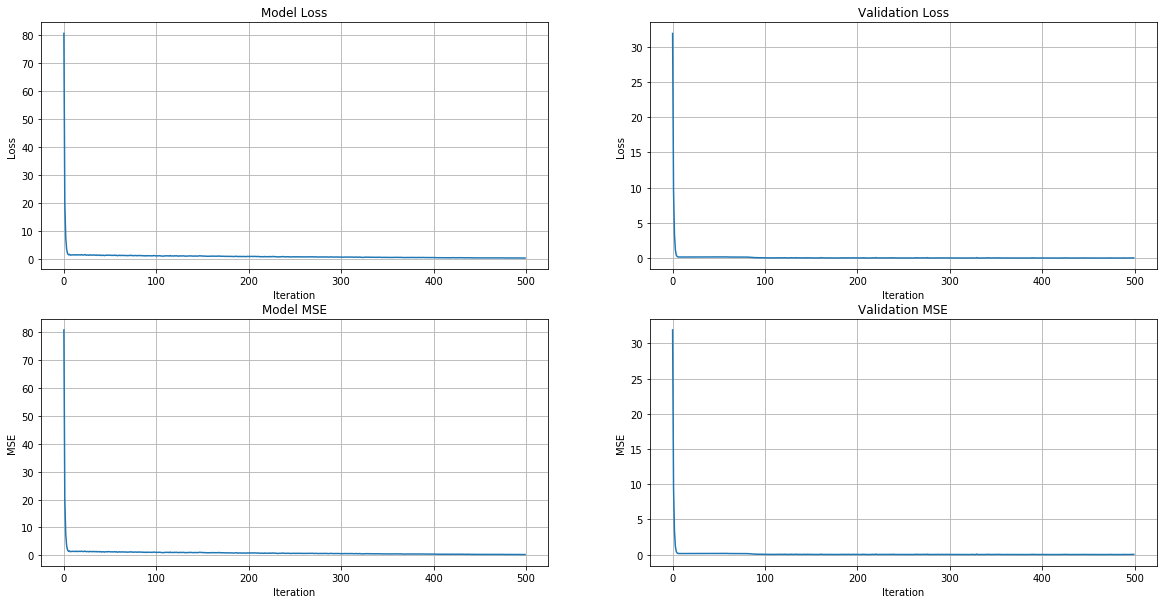

In [44]:
MLP = train_test_keras_regressor(x_train, y_train)

O último modelo desenvolvido será um modelo que agrega dois ou mais modelo em uma primeira camada e usa um meta-modelo para predizer os dados.

Esse meta-modelo é treinado com os dados preditos pelos modelos anteriores, dá seguinte forma:

Inicialmente cada um dos modelos é treinado nos dados de treinamento. Após isso, o vetor $x$ dos dados de treinamento é utilizado para predizer um vetor de dados (o qual seria muito próximo do vetor $y$ de treinamento). Cada modelo gera uma predição e todas elas são agrupadas para treinarem o meta-modelo.

O meta-modelo é treinado com esse conjunto de predições e o vetor $y$ do conjunto de treinamento.

As predições são realizads da mesma forma, passando primeiro por cada um dos modelos para no final servirem de entrada para o meta-modelo.

In [45]:
class StackingRegressors():
    """
    Essa clase implementa o método stacking para agrupar diferentes modelos de aprendizado de máquina.
    
    Parâmetros
    ----------
    estimators: list
        modelos de estimadores
    meta_model: estimador
        modelo para ser utilizado como meta-modelo
    
    """
    def __init__(self, estimators, meta_model):
        self.estimators = estimators
        self.meta_model = meta_model
    
    def fit(self, x, y=None):
        """
        Aqui cada um dos modelo é treinado e o novo conjunto de dados é gerado para alimentar o meta-modelo
        """
        self.models = []
        for model in self.estimators:
            self.models.append(model.fit(x, y))
        y_pred = np.zeros((x.shape[0], len(self.estimators)))
        for i, model in enumerate(self.models):
            y_pred[:, i] = model.predict(x)
        self.meta_model.fit(y_pred, y)
        self.coef_ = self.meta_model.coef_
        return self

    def predict(self, x, y=None):
        y_pred = np.zeros((x.shape[0], len(self.estimators)))
        for i, model in enumerate(self.models):
            y_pred[:, i] = model.predict(x)
        y_pred = self.meta_model.predict(y_pred)
        return y_pred

In [46]:
def train_test_stacked_regressors(x_train, y_train):
    """
    Essa função treina um modelo de stacking regressors.
    
    Parâmetros
    ----------
    
    x_train: pd.DataFrame
        conjunto de atributos do modelo
    y_train: np.ndarray
        variável a ser predita
    
    Retorno
    -------
    
    MP: 
        modelo stacking de regressores (pipeline envolvendo o padronizador dos dados)
        
    """
    GBR = GradientBoostingRegressor(
                                    loss = "huber",
                                    n_estimators = 250,
                                    alpha = 0.905,
                                    min_samples_split = 5,
                                    min_samples_leaf = 2,
                                    max_features = "sqrt",
                                    subsample = 1,
                                   )
    LA = Lasso(0.001)
    RI = Ridge(39)
    SR = StackingRegressors([LA, RI, GBR], LinearRegression())
    MP = make_pipeline(StandardScalerModified(), SR)
    score = cross_val_score(MP, x_train, y_train, cv = 5, scoring = "neg_mean_squared_error")
    score = np.sqrt(-1*score)
    score_list = score
    best_mean_score = np.mean(score)
    for i, score in enumerate(score_list):
        print("Iteração {}, score {:.4f}." .format(i, score))
    print("O melhor valor de score médio for {:.4f}" .format(best_mean_score))
    plt.figure(figsize = (20, 10))
    sns.barplot(np.arange(1, 6, 1), score_list)
    plt.grid()
    plt.title("Scores of cross-validation")
    plt.xlabel("CV")
    plt.ylabel("RMSE")
    MP.fit(x_train, y_train)
    return MP
    MP.fit(x_train, y_train)
    return MP

Iteração 0, score 0.0998.
Iteração 1, score 0.1387.
Iteração 2, score 0.1390.
Iteração 3, score 0.1180.
Iteração 4, score 0.1171.
O melhor valor de score médio for 0.1225


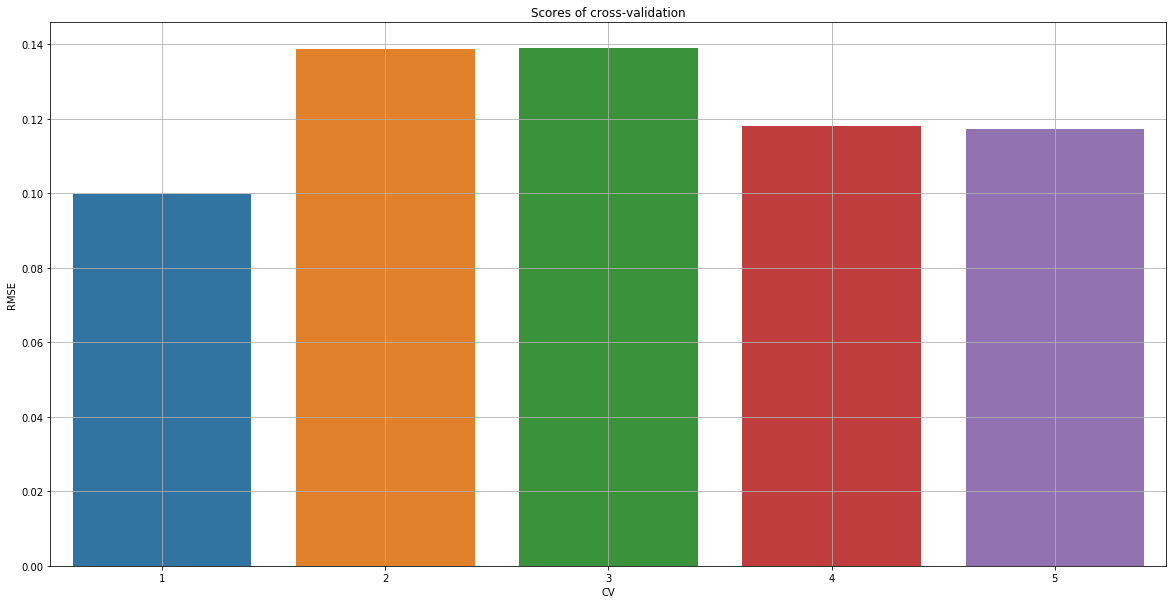

In [47]:
SR = train_test_stacked_regressors(x_train, y_train)

# Realizando predições no conjunto de testes

Para se verificar o desempenho dos modelos desenvolvidos, serão realizadas predições nos conjuntos de teste.

Esse conjunto de dados não foi utilizad em nenhum momento até essa etapa, para evitar que ocorra *overfitting*.

In [48]:
def test_linear_models(model, x_test, y_test):
    """
    Essa função realiza as predições e computa a raiz quadrada do erro quadrático médio do modelo.
    
    Parâmetros
    ----------
    
    model: modelo
        modelo a ter o desemepenho verificado
    x_test: np.ndarry
        array de dados contento o conjunto de atributos
    y_test: np.ndarray
        array de dados contendo a variável a ser predita
    
    """
    rmse = np.sqrt(mean_squared_error(y_test, model.predict(x_test)))
    print("The RMSE on test set is {:.4f}." .format(rmse))

In [49]:
test_linear_models(LR, x_test, y_test)

The RMSE on test set is 0.2321.


In [50]:
test_linear_models(RI, x_test, y_test)

The RMSE on test set is 0.2210.


In [51]:
test_linear_models(LA, x_test, y_test)

The RMSE on test set is 0.2281.


In [52]:
test_linear_models(GBR, x_test, y_test)

The RMSE on test set is 0.1497.


In [53]:
test_linear_models(SR, x_test, y_test)

The RMSE on test set is 0.1360.


In [54]:
def test_neural_model(model, x_train, y_train, x_test, y_test):
    """
    Essa função realiza as predições e computa a raiz quadrada do erro quadrático médio do modelo.
    
    Parâmetros
    ----------
    
    model: modelo
        modelo a ter o desemepenho verificado
    x_train: np.ndarry
        array de dados contendo o conjunto de atributos de treinamento
    y_train: np.ndarray
        arraya de dados de treinamento contendo a variável a ser predita
    x_test: np.ndarry
        array de dados contendo o conjunto de atributos
    y_test: np.ndarray
        array de dados contendo a variável a ser predita
    
    """
    SCM = StandardScalerModified()
    SCM.fit(x_train, y_train)
    x_test = SCM.transform(x_test)
    rmse = np.sqrt(model.evaluate(x_test, y_test, verbose = 0)[1])
    print("The RMSE on test set is {:.4f}." .format(rmse))

In [55]:
test_neural_model(MLP, x_train, y_train, x_test, y_test)

The RMSE on test set is 0.2096.


Pode-se verificar que o melhor modelo foi o *Stacking Regressor*, seguido pelo *Gradient Boosting Regressor*. O terceiro melhor modelo foi a regressão neural.

# Gerando predições para envio

Por fim, as predições são geradas para submissão.

In [56]:
def predict_data(model, x_train, y_train, x_test, neural_model=False):
    """
    Essa função realiza a predição dos dados de acordo com o modelo passado a ela.
    
    Parâmetros
    ---------
    
    model: modelo 
        modelo de aprendizado de máquina utilizado para realizar as predições
    x_train: np.ndarray
        conjunto de dados de treinamento
    y_train: np.ndarray
        conjunto de dados de treinamento (variável alvo)
    x_test: np.ndarray
        conjunto de dados de test
    neural_model: bool default = False
        variável indicando se o modelo passado a função é baseado em redes neurais ou não
    
    """
    if neural_model == True:
        SCM = StandardScalerModified()
        SCM.fit(x_train, y_train)
        x_test = SCM.transform(x_test)
        y_pred = model.predict(x_test)[:, 0]
    else:
        y_pred = model.predict(x_test)
    return y_pred

In [57]:
y_pred = predict_data(MLP, x_train, y_train, DF_Test_dummies)

In [58]:
DF_Test = pd.read_csv("Test.csv")

FileNotFoundError: [Errno 2] File b'Test.csv' does not exist: b'Test.csv'

In [ ]:
DF_Out = pd.DataFrame(data = {"Id": DF_Test["Id"], "SalePrice": np.exp(y_pred) - 1})

In [ ]:
DF_Out.to_csv("Predições/Predict.csv", index = False)